# Predicting Insurance Costs
In this project, we'll be using Linear Regression to predict medical insurance costs of individuals in the dataset. For this project, we'll be looking at the [Medical Cost Data Set](https://www.kaggle.com/datasets/mirichoi0218/insurance?resource=download) from Kaggle. This dataset contains information on individual medical insurance bills. Each bill is associated with some demographic and personal characteristics of the person who received it.

For our regression problem, we're interested in how these different characteristics relate to the total medical cost. It's a continuous, positive number, which makes it a good candidate for a linear regression. We want to construct the best possible predictive model for the cost, given some information about the patient.

Predicting medical costs is an important task because it allows hospitals to predict revenue and plan necessary procedures needed by its patient population.

In [1]:
import warnings
warnings.simplefilter(action='ignore')

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy.stats import boxcox

In [2]:
insurance = pd.read_csv('insurance.csv')
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [4]:
insurance.describe(include='all')

,age,sex,bmi,children,smoker,region,charges
count,1338.000000,1338,1338.000000,1338.000000,1338,1338,1338.000000
unique,NaN,2,NaN,NaN,2,4,NaN
top,NaN,male,NaN,NaN,no,southeast,NaN
freq,NaN,676,NaN,NaN,1064,364,NaN
mean,39.207025,NaN,30.663397,1.094918,NaN,NaN,13270.422265
std,14.049960,NaN,6.098187,1.205493,NaN,NaN,12110.011237
min,18.000000,NaN,15.960000,0.000000,NaN,NaN,1121.873900
25%,27.000000,NaN,26.296250,0.000000,NaN,NaN,4740.287150
50%,39.000000,NaN,30.400000,1.000000,NaN,NaN,9382.033000
75%,51.000000,NaN,34.693750,2.000000,NaN,NaN,16639.912515


We can see that the target variable is charges. Let's see how the predictors correlate with it, to determine what might be useful.

In [5]:
insurance.corr()['charges']

age         0.299008
bmi         0.198341
children    0.067998
charges     1.000000
Name: charges, dtype: float64

Let's use dummies on categorical variables and recheck correlation.

In [6]:
insurance_1 = insurance.copy()
insurance_1['sex'] = insurance_1['sex'].apply(lambda x: 1 if x.lower() == 'male' else 0)
insurance_1['smoker'] = insurance_1['smoker'].apply(lambda x: 1 if x.lower() == 'yes' else 0)
insurance_1 = pd.get_dummies(insurance_1)
insurance_1.head()

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,0,0,0,1
1,18,1,33.770,1,0,1725.55230,0,0,1,0
2,28,1,33.000,3,0,4449.46200,0,0,1,0
3,33,1,22.705,0,0,21984.47061,0,1,0,0
4,32,1,28.880,0,0,3866.85520,0,1,0,0


In [7]:
insurance_1.corr()['charges']

age                 0.299008
sex                 0.057292
bmi                 0.198341
children            0.067998
smoker              0.787251
charges             1.000000
region_northeast    0.006349
region_northwest   -0.039905
region_southeast    0.073982
region_southwest   -0.043210
Name: charges, dtype: float64

The smoker and the age features are significantly correlated with the target variable.

### Exploring The Dataset
The columns in the dataset are:
* age: age of primary beneficiary
* sex: insurance contractor gender (female or male)
* bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9
* children: Number of children covered by health insurance / Number of dependents
* smoker: Whether beneficiary is a smoker
* region: the beneficiary's residential area in the US (northeast, southeast, southwest, northwest).
* charges: Individual medical costs billed by health insurance

Let's check the correlations between each of the predictor variables

In [8]:
insurance_1.corr()

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
age,1.000000,-0.020856,0.109272,0.042469,-0.025019,0.299008,0.002475,-0.000407,-0.011642,0.010016
sex,-0.020856,1.000000,0.046371,0.017163,0.076185,0.057292,-0.002425,-0.011156,0.017117,-0.004184
bmi,0.109272,0.046371,1.000000,0.012759,0.003750,0.198341,-0.138156,-0.135996,0.270025,-0.006205
children,0.042469,0.017163,0.012759,1.000000,0.007673,0.067998,-0.022808,0.024806,-0.023066,0.021914
smoker,-0.025019,0.076185,0.003750,0.007673,1.000000,0.787251,0.002811,-0.036945,0.068498,-0.036945
charges,0.299008,0.057292,0.198341,0.067998,0.787251,1.000000,0.006349,-0.039905,0.073982,-0.043210
region_northeast,0.002475,-0.002425,-0.138156,-0.022808,0.002811,0.006349,1.000000,-0.320177,-0.345561,-0.320177
region_northwest,-0.000407,-0.011156,-0.135996,0.024806,-0.036945,-0.039905,-0.320177,1.000000,-0.346265,-0.320829
region_southeast,-0.011642,0.017117,0.270025,-0.023066,0.068498,0.073982,-0.345561,-0.346265,1.000000,-0.346265
region_southwest,0.010016,-0.004184,-0.006205,0.021914,-0.036945,-0.043210,-0.320177,-0.320829,-0.346265,1.000000


We find the following correlations:
* Southeast region is positively correlated with bmi
* Smoking is correlated with charges
* Age is correlated with charges
* bmi is correlated with charges

We'll review the relationships between the potential predictor variables with the outcome via plots. We'll determine if stratifying by a predictor shows a meaningful difference in the distribution of the outcome.

We'll be using the original dataframe

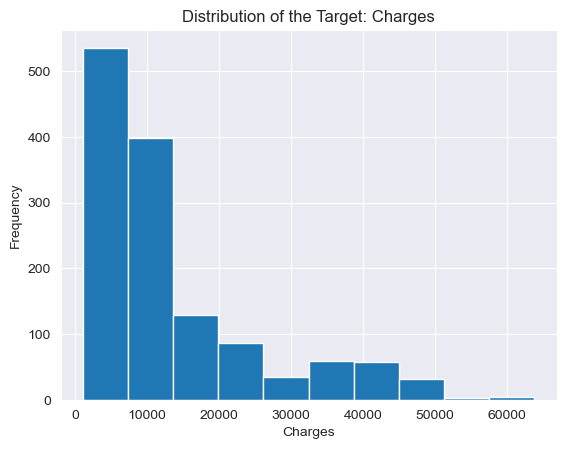

In [9]:
insurance['charges'].hist()
plt.title('Distribution of the Target: Charges')
plt.xlabel('Charges')
plt.ylabel('Frequency')
plt.show()

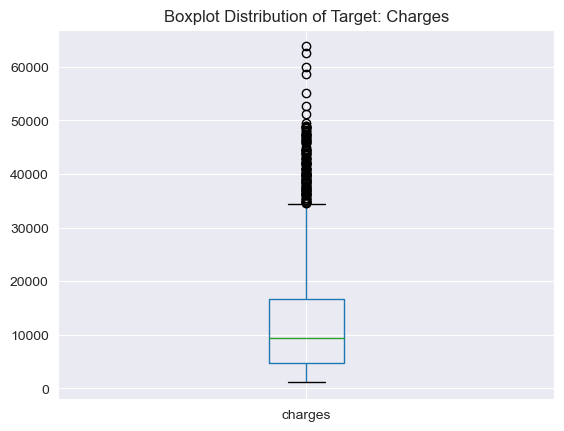

In [10]:
insurance[['charges']].boxplot()
plt.title('Boxplot Distribution of Target: Charges')
plt.show()

The target variable is right skewed, meaning most of the records are less than or equal to $10,000. Let's check the distribution of the target variable up to the 75th percentile, since the max value is a significant outlier.

(array([161., 122., 132., 115., 109.,  97., 109.,  85.,  52.,  21.]),
 array([ 1121.8739   ,  2673.6777615,  4225.481623 ,  5777.2854845,
         7329.089346 ,  8880.8932075, 10432.697069 , 11984.5009305,
        13536.304792 , 15088.1086535, 16639.912515 ]),
 <BarContainer object of 10 artists>)

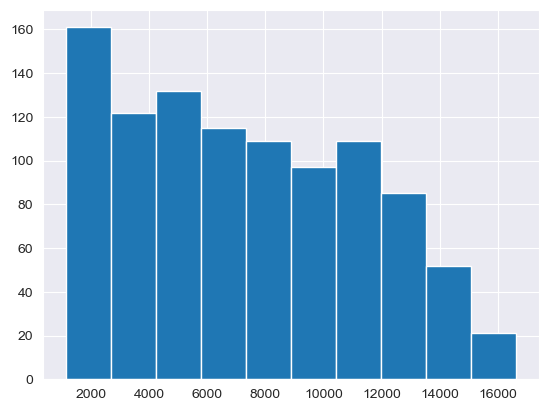

In [11]:
plt.hist(x=insurance['charges'], range=(insurance['charges'].min(),
                                        insurance['charges'].describe()[-2]))

This is still a right-skewed distribution but the spread is wider. Given the skew, it is unlikely that the errors in the model will be centered at zero. We'll log-transform the target.

array([[<AxesSubplot:title={'center':'log_charges'}>]], dtype=object)

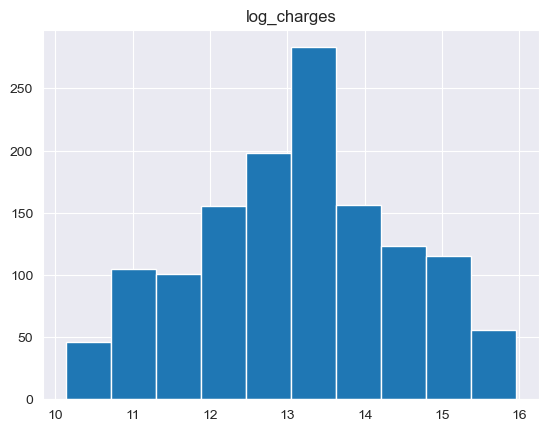

In [12]:
insurance['log_charges'] = np.log2(insurance['charges'])
insurance.hist('log_charges')

The log-transformed charges are more normally distributed making it more likely that errors will be unbiased.

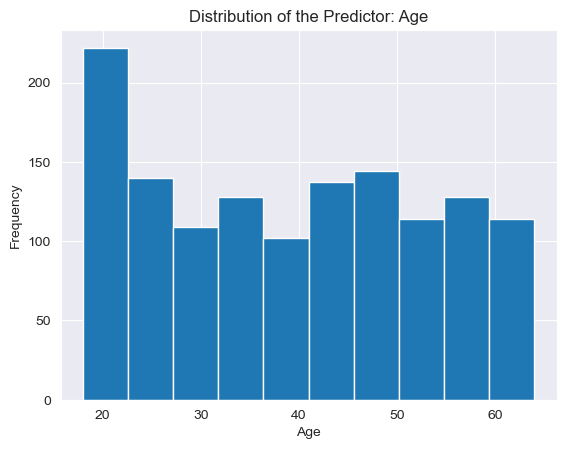

In [13]:
insurance['age'].hist()
plt.title('Distribution of the Predictor: Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

The Age distribution is uniform with a sharp peak around the < 23 age range.

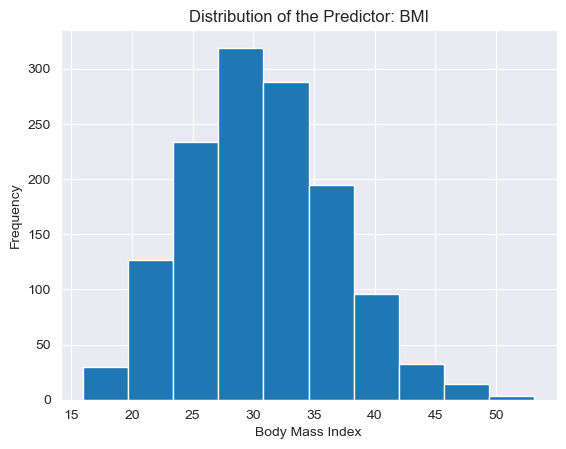

In [14]:
insurance['bmi'].hist()
plt.title('Distribution of the Predictor: BMI')
plt.xlabel('Body Mass Index')
plt.ylabel('Frequency')
plt.show()

The BMI distribution is normal. Let's plot these variables in a boxplot.

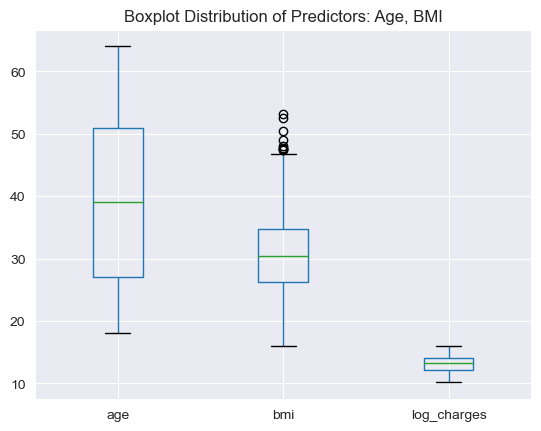

In [15]:
insurance.boxplot(column=['age', 'bmi', 'log_charges'])
plt.title('Boxplot Distribution of Predictors: Age, BMI')
plt.show()

We'll check the relationships between our potential predictor variables and the target via boxplots.

We'll use the following predictors - age, bmi, sex, region, smoker, and children. We'll chart region and smoker against bmi and charges, using sex as a classifier.

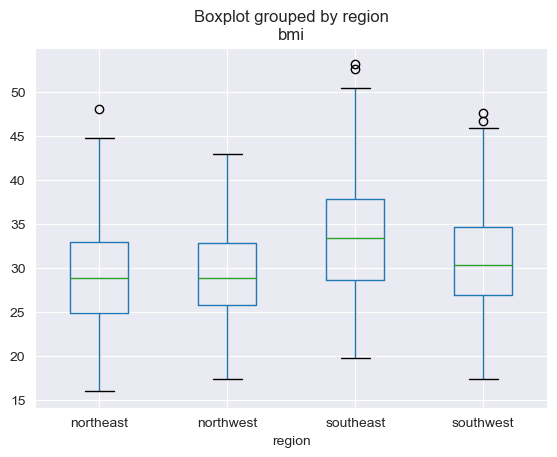

In [16]:
insurance.boxplot(column=['bmi'], by='region')
plt.show()

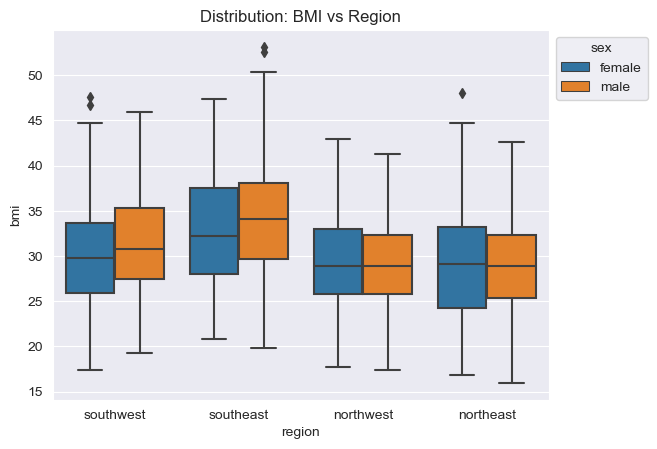

In [17]:
ax = sns.boxplot(x = insurance['region'],
                 y = insurance['bmi'],
                 hue = insurance['sex'])
sns.move_legend(ax, loc="upper left", bbox_to_anchor=(1, 1))
plt.title('Distribution: BMI vs Region')
plt.show()

The Southeast Region seems to have the highest BMI readings, while the Northwest has the lowest.

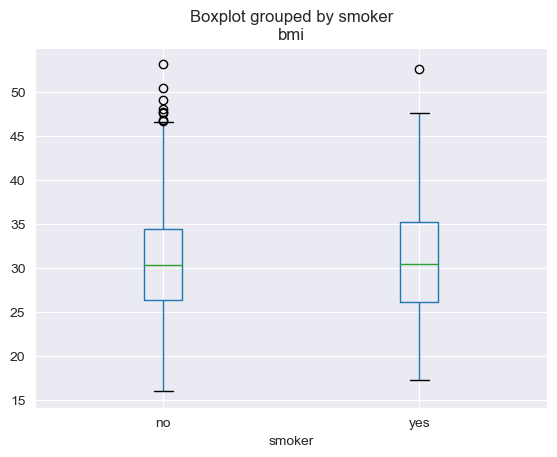

In [18]:
insurance.boxplot(column=['bmi'], by='smoker')
plt.show()

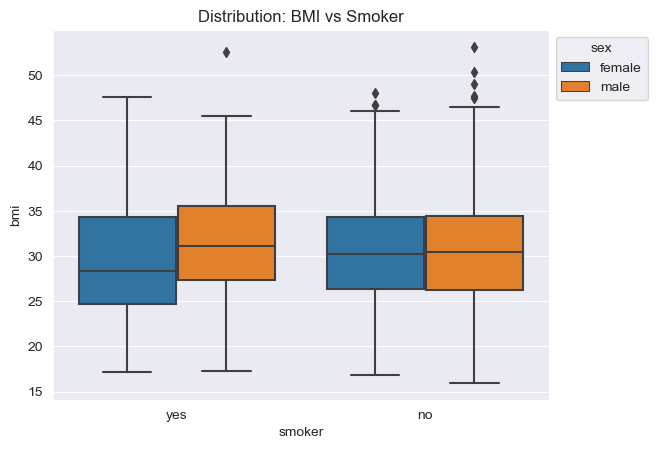

In [19]:
ax = sns.boxplot(x=insurance['smoker'],
                 y=insurance['bmi'],
                 hue=insurance['sex'])
sns.move_legend(ax, loc="upper left", bbox_to_anchor=(1, 1))
plt.title('Distribution: BMI vs Smoker')
plt.show()

Men who smoke have slightly higher BMIs than their non-smoking counterparts. We don't see this in the women plot but there's a wider BMI range for women who smoke.

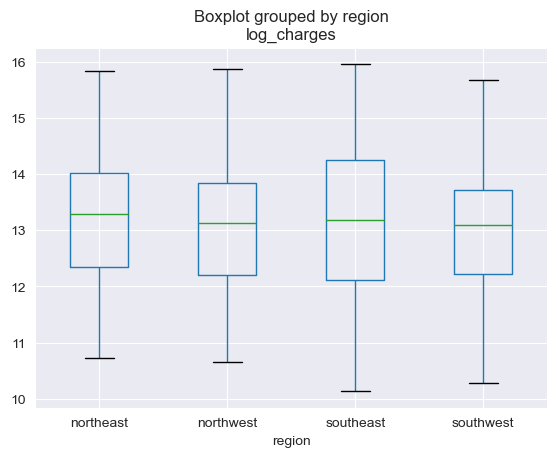

In [20]:
insurance.boxplot(column=['log_charges'], by='region')
plt.show()

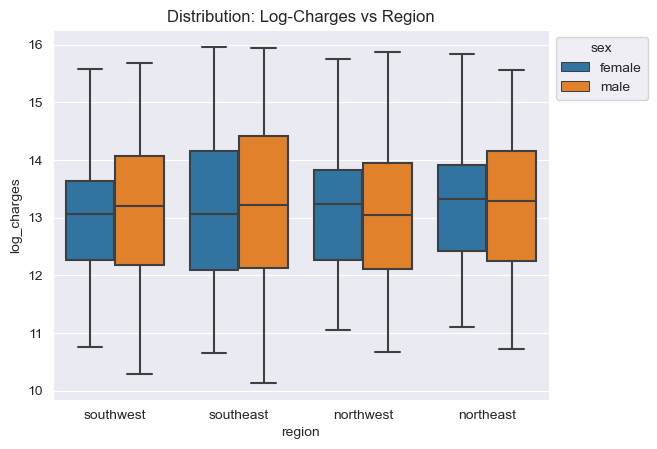

In [21]:
ax = sns.boxplot(x=insurance['region'],
                 y=insurance['log_charges'],
                 hue=insurance['sex'])
sns.move_legend(ax, loc="upper left", bbox_to_anchor=(1, 1))
plt.title('Distribution: Log-Charges vs Region')
plt.show()

In line with BMI, the highest charges are in the Southeast and the lowest are in the Northwest. Men generally have higher medical insurance costs than women. This presupposes a correlation between sex and charges.

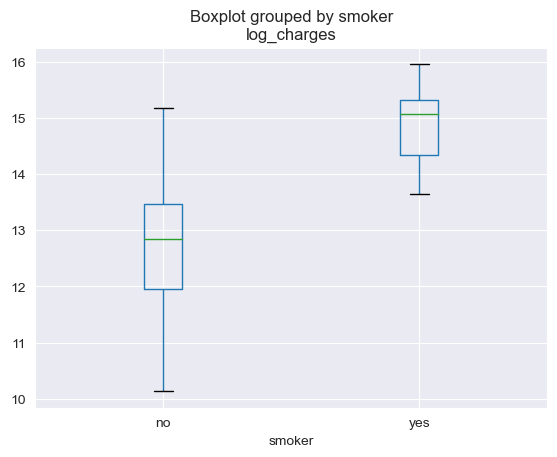

In [22]:
insurance.boxplot(column=['log_charges'], by='smoker')
plt.show()

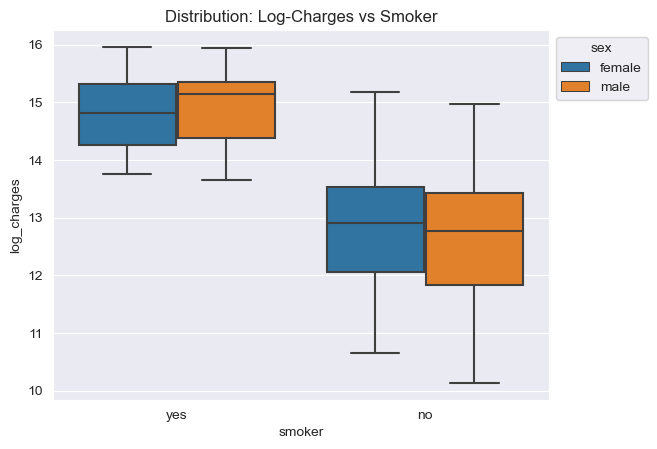

In [23]:
ax = sns.boxplot(x=insurance['smoker'],
                 y=insurance['log_charges'],
                 hue=insurance['sex'])
sns.move_legend(ax, loc="upper left", bbox_to_anchor=(1, 1))
plt.title('Distribution: Log-Charges vs Smoker')
plt.show()

Smokers have significantly higher charges than non-smokers although their distribution contains no outliers.

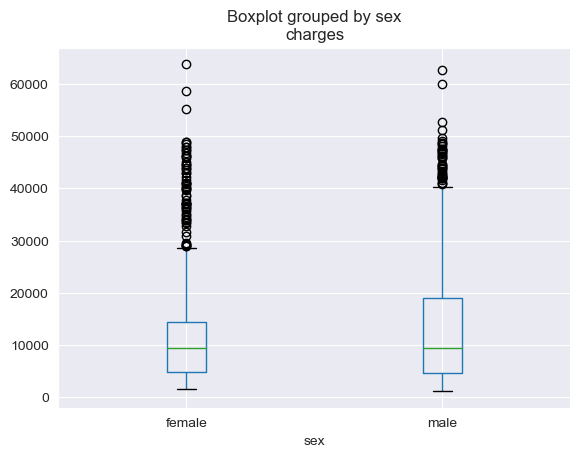

In [24]:
insurance.boxplot(column=['charges'], by='sex')
plt.show()

Generally, men have higher insurance costs than women.

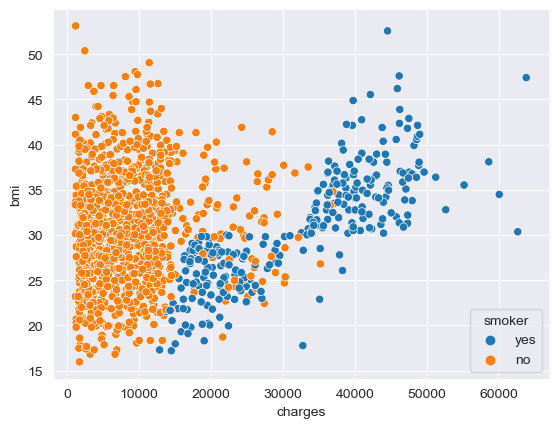

In [25]:
sns.scatterplot(data=insurance, x='charges', y='bmi', hue='smoker')
plt.show()

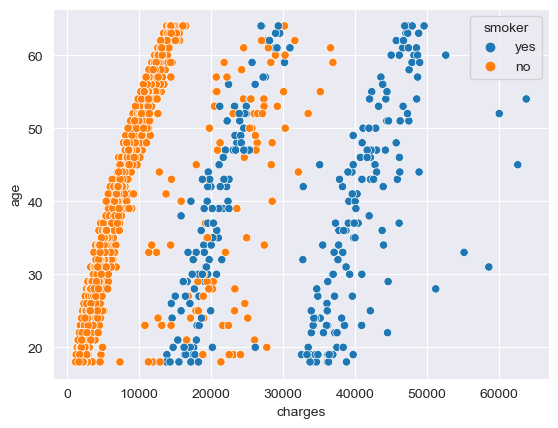

In [26]:
sns.scatterplot(data=insurance, x='charges', y='age', hue='smoker')
plt.show()

From the above analysis, we will use the following predictors
1. bmi
2. smoker
3. age
4. sex

We've selected these predictors because the correlation analysis (from correlation table and boxplot) shows that these variables are correlated with the target variable. These are some of the factors that determine cost of health insurance.

### Dividing the Data
We'll divide the insurance dataset into two portions:
1. A training set that will be used to estimate the regression coefficients
2. A test set that will be used to assess the predictive ability of the model

In [27]:
X = insurance_1.drop(columns=['charges', 'children',
                            'region_northeast', 'region_northwest',
                            'region_southeast', 'region_southwest'])
y = insurance['log_charges']

X.head()

,age,sex,bmi,smoker
0,19,0,27.900,1
1,18,1,33.770,0
2,28,1,33.000,0
3,33,1,22.705,0
4,32,1,28.880,0


In [28]:
y.head()

0    14.043448
1    10.752842
2    12.119415
3    14.424197
4    11.916945
Name: log_charges, dtype: float64

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=.2,
                                                    random_state=729)

### Building the Model
Now that we've divided up the data into both a training and test set, we're ready to build our predictive linear model. After we build the model, take the time to examine the regression coefficients and the coefficient of determination. We can ask ourselves a few things:
1. Do the coefficient values make sense considering their correlation with the outcome?
2. What does the coefficient of determination suggest about the model fit?
3. How well does the model predict the medical costs in the training set?

Let's build the model.

In [30]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

#### Interpreting the Coefficients
Let's examine the coefficients of the model: slope and intercept.
* The slope represents the change in the expected value of the outcome for a unit increase in the predictor.
* The intercept represents the average outcome when the predictors are equal to zero.

In [31]:
print('The model coefficients are: ', model.coef_)

The model coefficients are:  [ 0.0501727  -0.09469277  0.01756357  2.25794133]


All coefficients are positively correlated to the target, except sex.

In [32]:
print('The y-intercept value is: ', model.intercept_)

The y-intercept value is:  10.217462105030506


Let's test our model.

In [33]:
y_train_pred = model.predict(X_train)
y_train_pred[0:5]

array([12.37240411, 13.22068741, 11.44312936, 13.63626681, 11.82636296])

We will evaluate the quality of the linear regression model using a number of metrics:
* coefficient of determination (or rsquared)
* mean squared error (MSE)

Rsquared examines how well the model accounts for the variance in the outcome. We prefer a model with a higher rsquared value since it indicates that it best approximates the data.

MSE represents the average squared error of the model. We prefer a model with a lower MSE. The higher it is, the less accurate we would consider the model.

The RMSE is the standard deviation of the prediction errors (residuals). Residuals are a measure of how far from the regression line data points are; RMSE is a measure of how spread out these residuals are. In other words, it tells you how concentrated the data is around the line of best fit.

Let's evaluate the training data predictions.

In [34]:
R2_train = r2_score(y_train, y_train_pred)
R2_train

0.7420916448112155

In [35]:
train_mse = mean_squared_error(y_train, y_train_pred)
train_mse

0.46185369982496643

In [36]:
# MSE on the original scale for the insurance charges
rescaled_train_mse = np.exp(mean_squared_error(y_train, y_train_pred))
rescaled_train_mse

1.5870131059455783

The model's rsquared quotes a 75% accuracy and the MSE is 0.46. This suggests that the model is good at predicting insurance costs given the stated predictors.

### Residual Diagnostics
We have calculated the fitted values for all the data in the training set. This is in the *y_train_pred* variable, representing predictions made from the training data.

In order to determine residuals, we will subtract the predicted values from the true values. Then we'll plot the residuals against the fitted values.

In [37]:
residuals = y_train - y_train_pred
residuals.rename('residuals', inplace=True)
residuals.head()

863    0.041765
970    0.164992
248   -0.603852
765   -0.104566
942   -0.711665
Name: residuals, dtype: float64

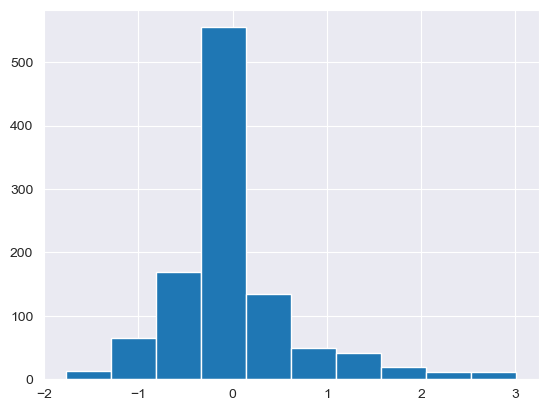

In [38]:
residuals.hist()
plt.show()

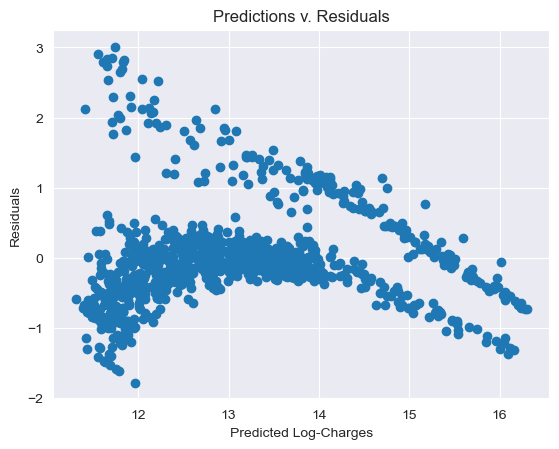

In [39]:
plt.scatter(y_train_pred, residuals)
plt.xlabel('Predicted Log-Charges')
plt.ylabel('Residuals')
plt.title('Predictions v. Residuals')
plt.show()

The residuals are generally centered around the zero value for lower to mid-range of predicted values, however as the predicted values increase, the residuals trend downward, toward the negative range.

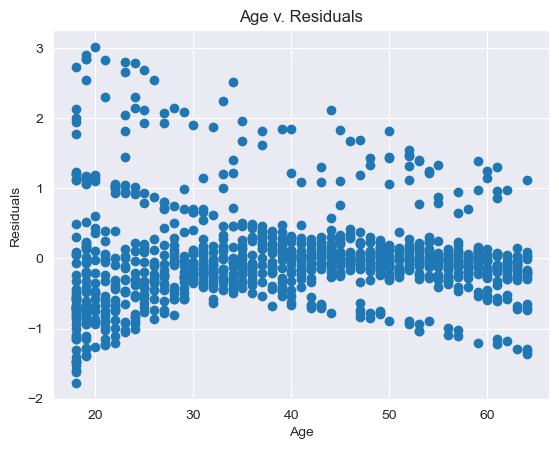

In [40]:
plt.scatter(X_train['age'], residuals)
plt.xlabel('Age')
plt.ylabel('Residuals')
plt.title('Age v. Residuals')
plt.show()

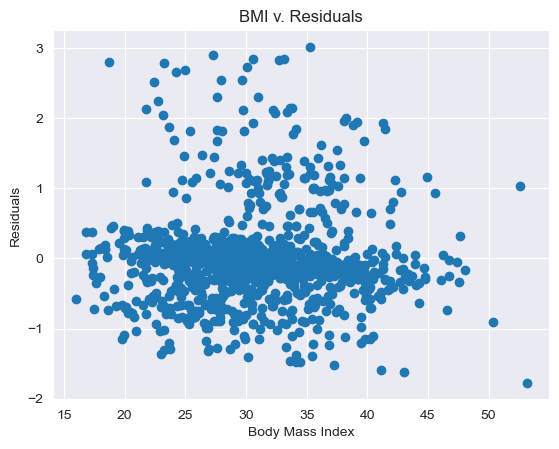

In [41]:
plt.scatter(X_train['bmi'], residuals)
plt.xlabel('Body Mass Index')
plt.ylabel('Residuals')
plt.title('BMI v. Residuals')
plt.show()

The age and BMI predictors generally trend with the residuals.

### Interpreting the Model
In a linear model, the slope/ coefficient is the average increase in the target for a unit increase in a predictor, holding the other predictors constant. In our model, the coefficients are:
1. age: 0.05
    * A year increase in the subject is associated with a 0.04 increase in the log charges, holding smoking status and bmi constant. This amounts to a 4% increase in the charges on the regular scale
2. sex: -0.09
3. bmi: 0.01
    * A unit increase in the subject BMI is associated with a 0.01 increase in the log charges, holding smoking status and age constant. This amounts to a 1.5% increase in the charges on the regular scale.
4. smoker: 2.25
    * A smoker is associated with a 2.23 increase in the log charges, holding age and bmi constant. This amounts to a 930% increase in the charges on the regular scale.

While other features only slightly affect the value of the target, the smoker feature has some significant effect on the value of the target. This means that a person who smokes is significantly more likely to have higher insurance costs, irrespective of other features in the person's profile.

The model's intercept is 10.21 (regular scale value of 27377.10). This means that if all predictors are equal to 0, the average cost of insurance is $27,377.10.

### Final Model Evaluation
We will now test our model using new data, that it has not been trained on.

In [42]:
y_pred = model.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred)
test_mse

0.38714006198954426

In [43]:
np.exp(test_mse)

1.47276275490953

In [44]:
R2 = r2_score(y_test, y_pred)
R2

0.7619484474448965

In [45]:
residuals = y_test - y_pred
residuals.rename('residuals', inplace=True)
residuals.head()

647     0.375747
992     0.023591
213    -0.104293
1203    0.033637
309     0.064629
Name: residuals, dtype: float64

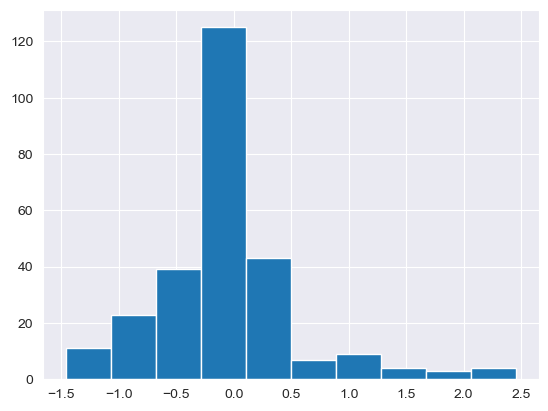

In [46]:
residuals.hist()
plt.show()

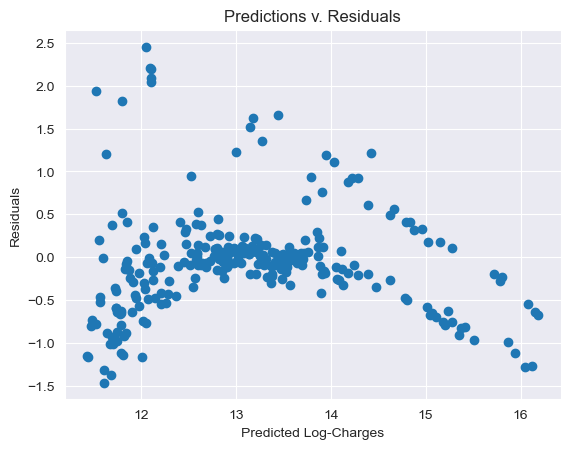

In [47]:
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Log-Charges')
plt.ylabel('Residuals')
plt.title('Predictions v. Residuals')
plt.show()

The MSE of the test model is slightly more accurate than the train model, with a lower score of 0.38 and a rsquared accuracy of 76%.

### Drawing Conclusions
The train MSE is 0.46 and the test MSE is 0.38. The errors in the models are not very identical which may imply that the model is overfit. The residuals suggest that the model is predicting much lower costs for subjects who were actually charged much higher. Therefore, the model struggles with these higher costs. As a whole, the model predictions are too conservative.

We might improve the model by including more complex terms in the regression, such as interactions or quadratic terms.